# 贷款预测之生成新特征

In [163]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from jupyterthemes import jtplot
jtplot.style(theme='grade3')


import pickle

In [144]:
train = pd.read_csv('../dataset/train.csv', header=0, index_col='Loan_ID')
test = pd.read_csv('../dataset/test.csv', header=0, index_col='Loan_ID')

df = pd.concat([train ,test], axis=0)

In [145]:
# 目标变量
target_var = 'Loan_Status'

# 分类变量
cat_col = train.select_dtypes(include=['object']).columns.tolist()
cat_col.remove(target_var)
# 连续变量
num_col = train.select_dtypes(exclude=['object']).columns.tolist()

num_col.remove('Credit_History')
cat_col.append('Credit_History')

In [147]:
df.dropna(axis=0, inplace=True)

### 连续变量之间的关系

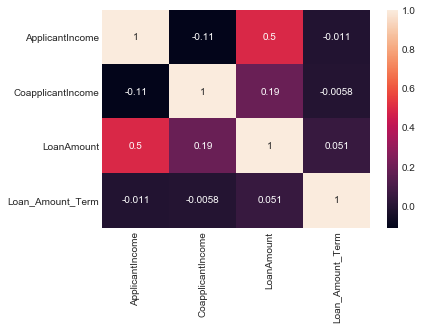

In [148]:
corr = df[num_col].corr()
sns.heatmap(corr, annot=True)

In [150]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
from scipy.stats import f_oneway
def get_p_value(data, columns, target):
    arg = []
    for s in data[target].unique():
        arg.append(data.loc[data[target]==s, columns])
    if len(data[target].unique())<=2:
        z, p = ztest(*arg)
    else:
        f, p = f_oneway(*arg)
    return p

In [87]:
stats_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in num_col:
    p = get_p_value(train, col, target_var)
    stats_result.loc[len(stats_result)] = [p, p<0.05, col]
stats_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
11,0.067871,False,Loan/TotalIncome
8,0.082022,False,Loan/Income
7,0.094299,False,Repayment
2,0.115766,False,LoanAmount
4,0.171201,False,TotalIncome
6,0.175019,False,AverageIncome
1,0.283265,False,CoapplicantIncome
0,0.345010,False,ApplicantIncome
9,0.412649,False,Income/Loan
5,0.438305,False,FamilySize


In [14]:
def plot_num(data, feature_name):
    s1 = data.loc[data[target_var]==1, feature_name]
    s2 = data.loc[data[target_var]==0, feature_name]
    s1mean = s1.mean()
    s1std = s1.std()
    s2mean = s2.mean()
    s2std = s2.std()
    print('Loan_Status==Yes, the mean={:.2f}(+/-{:.2f})'.format(s1mean, s1std))
    print('Loan_Status==No, the mean={:.2f}(+/-{:.2f})'.format(s2mean, s2std))
    if s1mean>s2mean:
        delta = s1mean-s2mean
    else:
        delta = s2mean-s1mean
    print('Absolute Mean Diferrence Distance: {:.2f}'.format(delta))
    print('p-value: {}'.format(stats_result.loc[stats_result['col']==feature_name, 'pvalue'].values[0]))
    print('p<0.05: {}'.format(stats_result.loc[stats_result['col']==feature_name, 'P<0.05'].values[0]))
    if feature_name in num_col:
        plt.figure(figsize=(15,5))
        _ = plt.subplot2grid((2,2),(0,0), rowspan=2)
        sns.pointplot(x=target_var, y=feature_name, data=data)
        
        _ = plt.subplot(2,2,2)
        sns.boxplot(y=feature_name, x=target_var, data=data)
        
        _ = plt.subplot(2,2,4)
        sns.kdeplot(data=data.loc[data[target_var]==1, feature_name], label='Y', shade=True)
        sns.kdeplot(data=data.loc[data[target_var]==0, feature_name], label='N', shade=True)
    else:
        plt.figure(figsize=(15,5))
        _ = plt.subplot2grid((2,2),(0,0), rowspan=2)
        sns.pointplot(x=target_var, y=feature_name, data=data)
        
        _ = plt.subplot(2,2,2)
        sns.boxplot(y=feature_name, x=target_var, data=data)
        
        _ = plt.subplot(2,2,4)
        sns.countplot(x=data.loc[data[target_var]==1, feature_name], data=df_train, color='darkgray')
        sns.countplot(x=data.loc[data[target_var]==0, feature_name], data=df_train, color='yellow')

### 分类变量分析

In [151]:
def get_chi2_value(data, columns, target=target_var):
    crosstable = pd.crosstab(data[columns], data[target])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    return p

In [153]:
from scipy.stats import chi2_contingency
chi2_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in cat_col:
    crosstable = pd.crosstab(train[col], train[target_var])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    chi2_result.loc[len(chi2_result)] = [p, p<0.05, col]
chi2_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
6,7.184760e-40,True,Credit_History
5,2.136019e-03,True,Property_Area
1,3.439381e-02,True,Married
3,4.309962e-02,True,Education
2,3.678507e-01,False,Dependents
0,7.086530e-01,False,Gender
4,9.420039e-01,False,Self_Employed


In [83]:
def plot_cat(data, feature_name):
    p = get_chi2_value(data, feature_name)
    crosstable = pd.crosstab(data[feature_name], data[target_var])
#     chi2, p, dof, expected = chi2_contingency(crosstable)
    # 不同特征值间离职和未离职的比例
    crosstable = crosstable.div(crosstable.sum(1), axis=0).round(4)
    crosstable.columns = ['No', 'Yes']
    print('\n 分类比例')
    print(crosstable)
    
    # 不同特征值在总体样本中所在比例
    percentage = (data[feature_name].value_counts() / len(data)).round(4)
    # 累计比例
    cumsum = percentage.cumsum().round(4)
    
    
    counttable = pd.DataFrame({'percentage': percentage, 'cumsum':cumsum},
                              index=data[feature_name].value_counts().index,
                              columns=['percentage', 'cumsum'])
    print('\n计数比例')
    print(counttable)
    
    yes_table = data[data[target_var]==1].groupby(feature_name)[target_var].sum()
    yes_percentage = (yes_table/yes_table.sum()).round(4)
    yestable = pd.DataFrame({'percentage': yes_percentage},
                            index=yes_table.index)
    yestable2 = yestable.reindex(index=counttable.index)
    yestable2['cumsum'] = yestable2['percentage'].cumsum()
    print('\n申请成功')
    print(yestable2)
    
    plt.figure(figsize=(15,7))
    ax1 = plt.subplot(2,2,1) # plt.subplot2grid((2,2),(0,0), rowspan=2)
    crosstable.plot(kind='bar', stacked=True, ax=ax1, rot=0)
    ax1.set_ylim([0,1.1])
    
    _ = plt.subplot(2,2,3)
    sns.barplot(x=feature_name, y=target_var, data=data, errwidth=0)
        
    _ = plt.subplot(2,2,2)
    sns.countplot(x=feature_name, data=data)

    _ = plt.subplot(2,2,4)
    sns.countplot(x=feature_name, data=data, hue=target_var)

## 分类变量间的关系

In [155]:
n = len(cat_col)
for x in range(n):
    for y in range(x, n):
        if x>= y:
            continue
        crosstable = pd.crosstab(df[cat_col[x]], df[cat_col[y]])
        chi2, p, dof, expected = chi2_contingency(crosstable)
        print('%s<-->%s, p=%f'%(cat_col[x], cat_col[y], p))


Gender<-->Married, p=0.000000
Gender<-->Dependents, p=0.000026
Gender<-->Education, p=0.250231
Gender<-->Self_Employed, p=0.910566
Gender<-->Property_Area, p=0.059060
Gender<-->Credit_History, p=0.746561
Married<-->Dependents, p=0.000000
Married<-->Education, p=0.934011
Married<-->Self_Employed, p=0.837840
Married<-->Property_Area, p=0.674738
Married<-->Credit_History, p=0.615633
Dependents<-->Education, p=0.886722
Dependents<-->Self_Employed, p=0.201808
Dependents<-->Property_Area, p=0.053520
Dependents<-->Credit_History, p=0.499816
Education<-->Self_Employed, p=0.957225
Education<-->Property_Area, p=0.332869
Education<-->Credit_History, p=0.280035
Self_Employed<-->Property_Area, p=0.502958
Self_Employed<-->Credit_History, p=0.742464
Property_Area<-->Credit_History, p=0.594904


## 连续变量与分类变量的关系

In [156]:
for x in num_col:
    for y in cat_col:
        p = get_p_value(df, x, y)
        print('%s<-->%s, p=%f'%(x, y, p))

ApplicantIncome<-->Gender, p=0.475176
ApplicantIncome<-->Married, p=0.421801
ApplicantIncome<-->Dependents, p=0.002453
ApplicantIncome<-->Education, p=0.003818
ApplicantIncome<-->Self_Employed, p=0.000151
ApplicantIncome<-->Property_Area, p=0.509118
ApplicantIncome<-->Credit_History, p=0.218843
CoapplicantIncome<-->Gender, p=0.000547
CoapplicantIncome<-->Married, p=0.023645
CoapplicantIncome<-->Dependents, p=0.902559
CoapplicantIncome<-->Education, p=0.102402
CoapplicantIncome<-->Self_Employed, p=0.973685
CoapplicantIncome<-->Property_Area, p=0.974227
CoapplicantIncome<-->Credit_History, p=0.849281
LoanAmount<-->Gender, p=0.029661
LoanAmount<-->Married, p=0.000045
LoanAmount<-->Dependents, p=0.000657
LoanAmount<-->Education, p=0.000125
LoanAmount<-->Self_Employed, p=0.008017
LoanAmount<-->Property_Area, p=0.054227
LoanAmount<-->Credit_History, p=0.372302
Loan_Amount_Term<-->Gender, p=0.051531
Loan_Amount_Term<-->Married, p=0.018075
Loan_Amount_Term<-->Dependents, p=0.029453
Loan_Amount

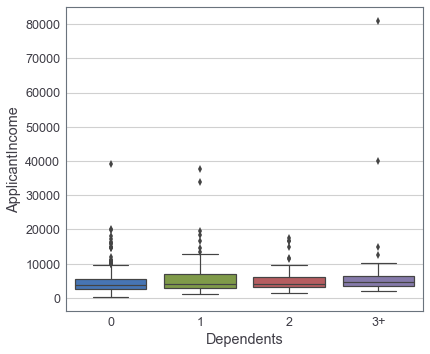

In [164]:
sns.boxplot(x='Dependents', y='ApplicantIncome', data=df, order=['0', '1', '2', '3+'])

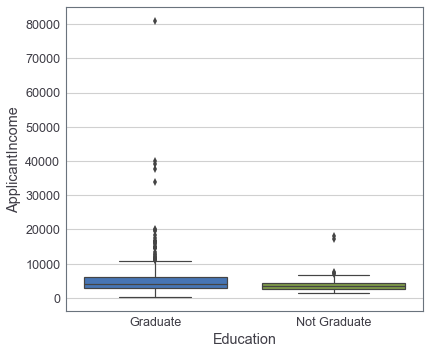

In [166]:
sns.boxplot(x='Education', y='ApplicantIncome', data=df)

In [179]:
sns.countplot(x='Married', y='Loan_Amount_Term', data=df, hue='Education')

TypeError: Cannot pass values for both `x` and `y`

In [181]:
train.groupby(['Married', 'Education'])['Loan_Amount_Term'].mean()

Married  Education   
No       Graduate        354.795181
         Not Graduate    336.571429
Yes      Graduate        338.970297
         Not Graduate    330.000000
Name: Loan_Amount_Term, dtype: float64

In [173]:
table

Education,Graduate,Not Graduate
Self_Employed,,
No,3859,3273
Yes,6250,4695
